In [1]:
import scipy.io
import numpy as np
import datetime 
import ephem
import random
from scipy import spatial
import matplotlib.pyplot as plt
%matplotlib
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import astropy
from astropy.time import Time
from astropy.coordinates import EarthLocation
import sunpy.coordinates
from datetime import datetime, timezone
from math import atan, atan2, degrees, floor, pi, radians, sin, sqrt
from skyfield.api import earth, JulianDate, now, sun
data=scipy.io.loadmat('BNS-sources-trial-10saleem.mat')['data'] 
#sourceparameters
DL=data[:,0]
theta=data[:,1]
phi=data[:,2]

Using matplotlib backend: MacOSX


In [2]:
length = 220000
Radius = 6371000   #Radius of earth

In [3]:
#snr at each detector
snrH=data[:,5]
snrL=data[:,6]
snrV=data[:,7]
snrK=data[:,8]
snrI=data[:,9]
#or for networks of 5 and 3 detectors, one can use directly,
snrLHVKI=np.sqrt(data[:,5]**2 + data[:,6]**2 + data[:,7]**2 +data[:,8]**2 + data[:,9]**2)  
# SNR at LHVKI
snrLHV=np.sqrt(data[:,5]**2 + data[:,6]**2 + data[:,7]**2 )  # LHV*
snrLHVK = np.sqrt(data[:,5]**2 + data[:,6]**2 + data[:,7]**2 + data[:,8]**2)
snrLHVI = np.sqrt(data[:,5]**2 + data[:,6]**2 + data[:,7]**2 + data[:,9]**2)
snrH, snrL, snrLHV,snrLHVK, snrLHVI

(array([1.50828927, 1.3218442 , 4.88369119, ..., 0.14711676, 1.92059118,
        3.73704228]),
 array([2.05597716, 0.7623997 , 3.94531224, ..., 0.87258219, 1.87887723,
        3.17437839]),
 array([2.60109925, 2.01527692, 6.56372816, ..., 2.09722166, 3.03471228,
        5.1190831 ]),
 array([2.9615534 , 2.05214273, 7.23216427, ..., 2.10021926, 3.04157166,
        5.57032074]),
 array([2.80024108, 2.33763304, 7.55768521, ..., 2.6656951 , 3.20978535,
        5.91029335]))

In [4]:
def radectolatlong(Ra,Dec,time): #input in degrees
    
    """
    Take the RA, Dec of GW trigger from the table and convert them to  longitude, latitude
    RA, Dec should be floating point numbers (not astropy.coordinates)
    time should be a astropy.Time.time object
    Output is in floating point numbers (not astropy.quantity or astropy.coordinates)
    """
    ra = np.deg2rad(Ra)
    dec = np.deg2rad(Dec)
    time_sid = (time.sidereal_time('apparent','greenwich')).rad
    Lat = dec
    Long = ra - time_sid 
    return Lat,Long #output in radians

def latlongtoradec(Lat,Long,time): #input in radians
    """
    Take the Lat, Long of GW trigger from the saleem's table and convert them to  RA and DEC.
    """
    time_sid = (time.sidereal_time('apparent','greenwich')).rad
    
    DEC = Lat
    RA = Long + time_sid
    ra = np.rad2deg(RA)            
    dec = np.rad2deg(DEC)
    return ra,dec #output in degree

def is_saa(lat, longi, time):
    """Return whether the satellite is in South Atlantic Anamoly or not.
    Hard bounds used from the data of RXTE and assumed that the SAA region is rectangular below the inclination of RXTE.
    
    ra - right ascention of the body in degrees
    dec - declination of the body in degrees
    time - UTC time in datetime format
    """
    # lat, longi = radec2latlong(ra, dec, time)
    #lat, longi = eci_ecef(ra, dec, time)
    lat = np.rad2deg(lat)
    longi = np.rad2deg(longi)
    if -23< lat <= -7 and -90<=longi<=-10:
        return True
    
#     if -90<=longi<=-10:
#         y = 7*longi/80 + 23/8
#         if lat < y:
#             return True
    if -100<=longi<=-35:
        y=14*longi/65+189/13
        if lat<=y:
            return True
    
    if -35<longi<-10:
        y=-14/25*longi-63/5
        if lat<y:
            return True
    
    
    if -10<=longi<=40:
        z = -9*longi/25 -43/5
        if lat<z: 
            return True
	

    if -50<= lat <=-23 and -90<=longi<=40:
        return True
    else: return False 

def getxyz(theta,phi):
    """
    Convert cartesian coordinates into theta phi for ANY FRAME OF REFERENCE
    Theta ranges from 0 to pi, and is a floating point number in RADIANS
    Phi ranges from 0 to 2*pi, and is a floating point number in RADIANS
    x,y z are floating point numbers - and make a unit vector
    """
    theta = np.pi/2 - theta
    x=np.sin(theta)*np.cos(phi)
    y=np.sin(theta)*np.sin(phi)
    z=np.cos(theta)
    return x,y,z
def getnorm(vec):
    """
    Takes in the vector and get its norm and returns unit vector
    """
    norm = np.linalg.norm(vec)
    #print (norm)
    return vec/norm

In [5]:
#df = pd.read_csv('/Users/jinaypatel/Desktop/Daksha/Events(triggers).csv')
#time = df.sort_values(by=['Time in jd'])
#t = time['Time in jd']
#homotime = Time(t,format='jd')

In [6]:
time1 = Time('2022-01-01T00:00:00') 
time2 = Time('2023-01-01T00:00:00')
homotime = Time(np.random.uniform(low=time1.jd, high=time2.jd, size=len(theta)), format="jd").sort()
"""
homotime gives random but uniform sorted time in jd format.
"""

'\nhomotime gives random but uniform sorted time in jd format.\n'

In [7]:
sunloc = astropy.coordinates.get_sun(homotime)   # Gives the sun's location

In [8]:
sunRA = sunloc.ra.deg  #sun's RA in earth's frame in degrees
sunDEC = sunloc.dec.deg #sun's DEC in earth's frame in degrees
sunDIST = sunloc.distance.AU*1.496e11 #sun distance from earth in m

In [9]:
"""
Given below is the TLE format data for the satellite, i.e Astrosat. 
"""

line0 = 'ASTROSAT' #Daksha
line1 = '1 40930U 15052A   22302.17850942  .00000772  00000-0  19439-4 0  9990'
line2 = '2 40930   5.9975   0.5159 0009292 339.1937  20.7998 14.76165238112787'
line3 = '2 40930   5.9975   0.5159 0009292 339.1937 200.7998 14.76165238112787'

# line0 = 'SWIFT'#BAT
# line1 = '1 28485U 04047A   22302.18405080  .00001301  00000-0  60140-4 0  9997'
# line2 = '2 28485  20.5572 277.8742 0011565 130.4507 229.6936 15.03911323708409'
# line0 = 'FGRST (GLAST)'#Fermi
# line1 = '1 33053U 08029A   22100.45970249  .00000511  00000-0  12538-4 0  9998'
# line2 = '2 33053  25.5819 140.4060 0012690 120.1881 239.9912 15.11069703542313'
astrosat1 = ephem.readtle(line0,line1,line2)
astrosat2 = ephem.readtle(line0,line1,line3)
Radius = 6400000                              #radius of earth in m
alt1 = np.empty(length,dtype=object)          # Altiude of satellite from the surface of earth
alt2 = np.empty(length,dtype=object)
sublat1 = np.empty(length,dtype = object)
sublong1 = np.empty(length,dtype = object)
sublat2 = np.empty(length,dtype = object)
sublong2 = np.empty(length,dtype = object)
for i in range(length):
    time = (homotime[i].iso)
    astrosat1.compute(time)
    astrosat2.compute(time)
    alt1[i] = astrosat1.elevation
    alt2[i] = astrosat2.elevation
    sublat1[i] = (astrosat1.sublat)          #sublat in radians
    sublong1[i] = (astrosat1.sublong)        #sublong in radian
    sublat2[i] = (astrosat2.sublat)  #sublat in radians
    sublong2[i] = (astrosat2.sublong)

In [10]:
satunit1 = np.empty(length,dtype=object)   
satunit2 = np.empty(length,dtype=object)   
satvecold = np.empty(length,dtype=object)
"""
satunit1 is the vector from earth's center to satellite
"""

for i in range(length-1):
    satunit1[i] = getxyz(sublat1[i],sublong1[i])
    satunit2[i] = getxyz(sublat2[i],sublong2[i])
    #for satellite
    #time = str(homotime[i].iso)
    #astrosat1.compute(time)
    s = (getnorm(getxyz(sublat1[i],sublong1[i])))
    satvecold[i] = np.array([s[0]*(alt1[i]+Radius),s[1]*(alt1[i]+Radius),s[2]*(alt1[i]+Radius)])

In [11]:
RA = (sunRA+180) % 360  #RA is in degrees
DEC = -sunDEC   #DEC is in degrees

Text(0,0.5,'RA in deg.')

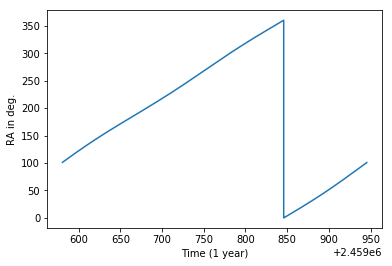

In [32]:
plt.plot(homotime.value,RA)
plt.xlabel("Time (1 year)")
plt.ylabel("RA in deg.")

In [12]:
"""
Distance is 1 m as we can get unit vector.
"""
c = SkyCoord(ra=RA*u.degree, dec=DEC*u.degree, distance=1*u.m)
sx = c.cartesian.x   #vector components from sun to earth/satellite in ICRS frame
sy = c.cartesian.y
sz = c.cartesian.z


In [13]:
sv = np.empty(length,dtype = object)
for i in range(0,length):
    sv[i] = np.array([sx[i]/u.m,sy[i]/u.m,sz[i]/u.m])

In [36]:
#import import_ipynb
#from Sensitivity import randomlumino


In [15]:
def randomlumino(number):
    """
    Returns 'number' of Luminosity values between the given caps
    """
    lumino = []
    lummax = -6
    lummin = -7
    factor = 10**6
    for i in range(number):
        #case1
        lumino.append(10**(random.randint(lummin*factor,lummax*factor)/factor))
        lumino[i] = lumino[i]*(200**2)/((DL[i])**2)
#         #case2
#         lumino.append(10**lummax)
#         lumino[i] = lumino[i]*(200**2)/((DL[i])**2)
#         #case3
#         if DL[i]<=200:
#             lumino.append(10**(random.randint(lummin*factor,lummax*factor)/factor))
#             lumino[i] = lumino[i]*(200**2)/((DL[i])**2)
#         else:
#             lumino.append(0.0)
#             lumino[i] = 0
#         #case4
#         if DL[i]<=200:
#             lumino.append(10**(lummin))
#             lumino[i] = lumino[i]*(200**2)/((DL[i])**2)
#         else:
#             lumino.append(0.0)
#             lumino[i] = 0
    return lumino
    
#         if DL[i]<=200:
#             lumino.append(10**(random.randint(lummin*factor,lummax*factor)/factor))
# #             lumino.append(10**(lummin))
#             lumino[i] = lumino[i]*(200**2)/((DL[i])**2)
#         else:
#             lumino.append(0.0)
# #             lumino[i] = 0
# #         lumino[i] = lumino[i]*(200**2)/((DL[i])**2)
# #         lumino.append(10**lummax)
        
#     return lumino

lumino = randomlumino(len(homotime))
# len(homotime)
# print(lumino)

def is_visible(time,latsat,longsat, lattrig, longtrig, satephem):
    """
    Check for the visibility of source, i.e whethear the source is block by earth or not.
    """
    satephem.compute(time)
    theta = 2*np.arcsin(6400000/(6400000+satephem.elevation))
    xsat,ysat,zsat = getxyz(latsat,longsat)
    satvec = (xsat,ysat,zsat)
    xtrig,ytrig,ztrig = getxyz(lattrig,longtrig)
    trigvec = (xtrig,ytrig,ztrig)
    
    anglebetween = np.arccos(np.dot(satvec,trigvec))
    omegatrig = 2*np.pi*(1- np.cos(np.pi-anglebetween))
    omegashadow = 2*np.pi*(1- np.cos((theta/2)))
#     omegashadow = 2*np.pi*(1-np.cos(np.deg2rad(180-38.7394)))
    if omegashadow>omegatrig:
        return False
    else:
        return True

In [16]:
sensfile = np.loadtxt('/Users/jinaypatel/Desktop/Daksha/sensitivity_20det.csv', delimiter=',',skiprows=1)

In [17]:
def transform_antisun(astrosat):   
    """Transforming coordinate system to satellite's frame for anti-sun orbit. 
zaxis is the axis from sun to earth. 
satvecold is the vector from earth to satellite. 
Cross product of zaxis and satvecold will give an axis perpendicular to zaxis which I defined is xaxis. 
And again doing cross product of xaxis and zaxis gives yaxis."""
    thetatransarray = []
    phitransarray = []
    for i in range(len(theta)):
        if i%10000==0:
            print(i, end=' ')
        time = homotime[i].iso
        astrosat.compute(time)
        satvecold = getnorm(getxyz(astrosat.sublat,astrosat.sublong))
        zaxis = sv[i]
        xaxis = getnorm(np.cross(zaxis,satvecold))
        yaxis = getnorm(np.cross(zaxis,xaxis))

        xtrig,ytrig,ztrig = getxyz(theta[i],phi[i])
        trigvec = getnorm([xtrig,ytrig,ztrig])

        thetatrans = np.arccos(np.dot(trigvec,zaxis))
        yprojtrig = np.linalg.norm(trigvec)*np.dot(trigvec,yaxis)
        xprojtrig = np.linalg.norm(trigvec)*np.dot(trigvec,xaxis)
        phitrans = np.arctan2(yprojtrig, xprojtrig)
        thetatransarray.append(thetatrans)
        phitransarray.append(phitrans)
    return thetatransarray,phitransarray

theta1_antisun,phi1_antisun = transform_antisun(astrosat1)
theta2_antisun,phi2_antisun = transform_antisun(astrosat2)

0 

10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 210000 0 10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 210000 

In [18]:

def transform_antiearth(astrosat):  
    """Transforming coordinate system to satellite's frame for anti-sun orbit.
satvecold is vector from earth to satellite and is zaxis.
satvecplus is vector from earth to satellite after tplus time.
temporary xaxis is the difference of satvecplus and satvecold.
yaxis is obtain from cross product of zaxis and temporary xaxis.
xaxis is obtain from cross product of zaxis and yaxis.
"""
#transforming coordinate system to satellite's frame.
    thetatransarray = []
    phitransarray = []
    for i in range(len(theta)):
        if i%10000==0:
            print(i, end=' ')
        time = homotime[i].iso
        astrosat.compute(time)
        satvecold = getnorm(getxyz(astrosat.sublat,astrosat.sublong))
        tplus = time[0:17]+(str(int(time[17:19])+1)) + time[19:23]
        astrosat.compute(tplus)
        satvecplus = getnorm(getxyz(astrosat.sublat,astrosat.sublong))

        zaxis = getnorm(satvecold)
        xaxistemp = getnorm([satvecplus[0]-satvecold[0],satvecplus[1]-satvecold[1],satvecplus[2]-satvecold[2]])
        yaxis = getnorm(np.cross(zaxis,xaxistemp))
        xaxis = getnorm(np.cross(yaxis,zaxis))

        xtrig,ytrig,ztrig = getxyz(theta[i],phi[i])
        trigvec = getnorm([xtrig,ytrig,ztrig])

        thetatrans = np.arccos(np.dot(trigvec,zaxis))
        yprojtrig = np.linalg.norm(trigvec)*np.dot(trigvec,yaxis)
        xprojtrig = np.linalg.norm(trigvec)*np.dot(trigvec,xaxis)
        phitrans = np.arctan2(yprojtrig, xprojtrig)
        thetatransarray.append(thetatrans)
        phitransarray.append(phitrans)
    return thetatransarray,phitransarray

theta1_antiearth,phi1_antiearth = transform_antiearth(astrosat1)
theta2_antiearth,phi2_antiearth = transform_antiearth(astrosat2)

0 

10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 210000 0 10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 210000 

In [20]:
sensitivitydata1 = []
sensitivitydata2 = []
sensfilethetaphi = []
for i in range(len(sensfile)):
    sensfilethetaphi.append((sensfile[i][0], sensfile[i][1]))

In [24]:
#theta1 = theta1_antiearth 
#theta2 = theta2_antiearth 
theta1 = theta1_antisun 
theta2 = theta2_antisun 
#phi1 = phi1_antiearth
#phi2 = phi2_antiearth
phi1 = phi1_antisun
phi2 = phi2_antisun

In [22]:
"""
Finding nearest neighbours using KDTree.
"""
for j in range(len(theta)):
    if j%100==0:
        print(int(j*100/len(theta)),'% Completed', end='\r')
    vectrig = [theta1[j],phi1[j]]
    nearest = sensfilethetaphi[spatial.KDTree(sensfilethetaphi).query(vectrig)[1]]
    for i in range(len(sensfilethetaphi)):
        if sensfilethetaphi[i][0] == nearest[0]:
            if sensfilethetaphi[i][1]==nearest[1]:
                index=i
    
    sensitivitydata1.append(sensfile[index][3])

for j in range(len(theta)):
    if j%100==0:
        print(int(j*100/len(theta)),'% Completed', end='\r')
    vectrig = [theta2[j],phi2[j]]
    nearest = sensfilethetaphi[spatial.KDTree(sensfilethetaphi).query(vectrig)[1]]
    for i in range(len(sensfilethetaphi)):
        if sensfilethetaphi[i][0] == nearest[0]:
            if sensfilethetaphi[i][1]==nearest[1]:
                index=i
    
    sensitivitydata2.append(sensfile[index][3])

NameError: name 'phi2' is not defined

In [26]:
for k in range(len(sensitivitydata2)):
    if np.isnan(sensitivitydata2[k])==True:
        sensitivitydata2[k] = 0
        
sensdatabackup2 = sensitivitydata2

for k in range(len(sensitivitydata1)):
    if np.isnan(sensitivitydata1[k])==True:
        sensitivitydata1[k] = 0
        
sensdatabackup1 = sensitivitydata1

In [27]:
numtrig = 0
for i in range(len(lumino)):
    if lumino[i]>0:numtrig = numtrig + 1
line1=[] #DD
line2=[] #LIGO
line3=[] #DD + LIGO
line4=[] #D : chosen without any reason as the first among these two (ephem = astrosat1)
line5=[] #D + LIGO
line6=[] #DD detections which LIGO didn't see
line7=[] #D detections which LIGO didn't see
print(numtrig)
# senssattemp = 1.4*10**(-7)
# senssattemp = 7.0*10**(-8)
for i in range(12):
    time = homotime[i].iso
    snr=i
    print('\nSNR =', snr)
    boolvis = []
    countsaa1, countsens1, countearth1, countvis1= 0,0,0,0
    countsaa2, countsens2, countearth2, countvis2 = 0,0,0,0
    count1sat,count1sat = 0,0
    count2sat,count2sat = 0,0
    count0sat,count0sat = 0,0
    vis1, vis2 = 0,0
    satd0, satd1, satd2 = 0,0,0
    dnol, ddnol0, ddnol1,ddnol2 = 0,0,0,0
    lowsnr = 0
    for i in range(len(homotime)):
        if i%10000==0:
            print(int(i*100/len(homotime)),'%',end='\r', flush=True)
        if snrLHVKI[i]<snr:
                lowsnr=lowsnr + 1
        if lumino[i]>0:
            satyes, yes, var3 = 0,0,0
            if is_saa(sublat1[i],sublong1[i], time)==True:
                countsaa1=countsaa1 + 1
            if sensitivitydata1[i]>lumino[i]:
                countsens1=countsens1+1
            if is_visible(time,sublat1[i],sublong1[i],np.deg2rad(90.0) - theta1[i],phi1[i], astrosat1)==False:
                countearth1 = countearth1 +1
            if is_saa(sublat1[i],sublong1[i], time)==False and snrLHVKI[i]>=snr and sensitivitydata1[i]<=lumino[i] and is_visible(time,sublat1[i],sublong1[i],np.deg2rad(90.0) - theta1[i],phi1[i], astrosat1)==True:
                countvis1 = countvis1+1
                satyes = satyes + 1
            if is_saa(sublat1[i],sublong1[i], time)==False and sensitivitydata1[i]<=lumino[i] and is_visible(time,sublat1[i],sublong1[i],np.deg2rad(90.0) - theta1[i],phi1[i], astrosat1)==True:
                vis1 = vis1+1
                yes = yes + 1
            if is_saa(sublat1[i],sublong1[i], time)==False and snrLHVKI[i]<snr and sensitivitydata1[i]<=lumino[i] and is_visible(time,sublat1[i],sublong1[i],np.deg2rad(90.0) - theta1[i],phi1[i], astrosat1)==True:
                var3=var3+1
                dnol=dnol+1
                
            if is_saa(sublat2[i],sublong2[i], time)==True:
                countsaa2=countsaa2 + 1
            if sensitivitydata2[i]>lumino[i]:
                countsens2=countsens2+1
            if is_visible(time,sublat2[i],sublong2[i],np.deg2rad(90.0) - theta2[i],phi2[i], astrosat1)==False:
                countearth2 = countearth2 +1
            if is_saa(sublat2[i],sublong2[i], time)==False and snrLHVKI[i]>=snr and sensitivitydata2[i]<=lumino[i] and is_visible(time,sublat2[i],sublong2[i],np.deg2rad(90.0) - theta2[i],phi2[i], astrosat2)==True:
                countvis2 = countvis2+1
                satyes = satyes + 1
            if is_saa(sublat2[i],sublong2[i], time)==False and sensitivitydata2[i]<=lumino[i] and is_visible(time,sublat2[i],sublong2[i],np.deg2rad(90.0) - theta2[i],phi2[i], astrosat2)==True:
                vis2 = vis2+1
                yes = yes + 1           
            if is_saa(sublat2[i],sublong2[i], time)==False and snrLHVKI[i]<snr and sensitivitydata2[i]<=lumino[i] and is_visible(time,sublat2[i],sublong2[i],np.deg2rad(90.0) - theta2[i],phi2[i], astrosat2)==True:
                var3=var3+1

            if satyes==0:
                count0sat=count0sat+1
            if satyes==1:
                count1sat=count1sat+1
            if satyes==2:
                count2sat=count2sat+1
            if yes==0:
                satd0=satd0+1
            if yes==1:
                satd1=satd1+1
            if yes==2:
                satd2=satd2+1
            if var3==0:
                ddnol0=ddnol0+1
            if var3==1:
                ddnol1=ddnol1+1
            if var3==2:
                ddnol2=ddnol2+1
    
    print('***100% Completed***\n',end='\r',flush=True)        
    print('lowsnr', lowsnr,'\t', lowsnr*100/numtrig)
    print('goodsnr', numtrig - lowsnr,'\t', (numtrig - lowsnr)*100/numtrig)
    print('\nDL')
    print('countvis1', countvis1,'\t', countvis1*100/(numtrig-lowsnr))
    print('countvis2', countvis2,'\t', countvis2*100/(numtrig-lowsnr))
    print('oD')
    print('vis1', vis1,'\t', vis1*100/(numtrig))
    print('vis2', vis2,'\t', vis2*100/(numtrig))
    print('\nDL', count0sat, count1sat, count2sat)
    print('oD', satd0, satd1, satd2)
    print((count1sat+count2sat+count0sat)*100/numtrig, '-- should be equal to 100%\n')
    print((count1sat+count2sat), '\t',(count1sat+count2sat)*100/(numtrig-lowsnr) ,'(' + str(count1sat*100/numtrig+count2sat*100/numtrig)+ ')')
    print('Line 1 element(Seen by D-Daksha)                      ', satd1+satd2)
    print('Line 2 element(Seen by Ligo network)                  ', len(homotime)-lowsnr)
    print('Line 3 element(Seen by both D-Daksha & LIGO)          ', count1sat+count2sat)
    print('Line 4 element(Seen by only one Daksha)               ', vis1)
    print('Line 5 element(Seen by both Daksha & LIGO)            ', countvis1)
    print('Line 6 element(LIGO missed which D-Dakhsa detected)   ', ddnol1+ddnol2)
    print('Line 7 element(LIGO missed which Daksha detected)     ', dnol)
    line1.append(satd1+satd2)
    line2.append(len(homotime)-lowsnr)
    line3.append(count1sat+count2sat)
    line4.append(vis1)
    line5.append(countvis1)
    line6.append(ddnol1+ddnol2)
    line7.append(dnol)

220000

SNR = 0


***100% Completed***
lowsnr 0 	 0.0
goodsnr 220000 	 100.0

DL
countvis1 84546 	 38.43
countvis2 84484 	 38.40181818181818
oD
vis1 84546 	 38.43
vis2 84484 	 38.40181818181818

DL 120918 29134 69948
oD 120918 29134 69948
100.0 -- should be equal to 100%

99082 	 45.03727272727273 (45.03727272727272)
Line 1 element(Seen by D-Daksha)                       99082
Line 2 element(Seen by Ligo network)                   220000
Line 3 element(Seen by both D-Daksha & LIGO)           99082
Line 4 element(Seen by only one Daksha)                84546
Line 5 element(Seen by both Daksha & LIGO)             84546
Line 6 element(LIGO missed which D-Dakhsa detected)    0
Line 7 element(LIGO missed which Daksha detected)      0

SNR = 1
***100% Completed***
lowsnr 156 	 0.07090909090909091
goodsnr 219844 	 99.9290909090909

DL
countvis1 84502 	 38.43725550845145
countvis2 84440 	 38.4090536926184
oD
vis1 84550 	 38.43181818181818
vis2 84482 	 38.40090909090909

DL 120974 29110 69916
oD 120917 29134 699

***100% Completed***
lowsnr 205222 	 93.28272727272727
goodsnr 14778 	 6.717272727272727

DL
countvis1 9172 	 62.06523210177291
countvis2 9104 	 61.60508864528353
oD
vis1 84609 	 38.458636363636366
vis2 84424 	 38.374545454545455

DL 209392 2940 7668
oD 120911 29145 69944
100.0 -- should be equal to 100%

10608 	 71.78237921234268 (4.821818181818182)
Line 1 element(Seen by D-Daksha)                       99089
Line 2 element(Seen by Ligo network)                   14778
Line 3 element(Seen by both D-Daksha & LIGO)           10608
Line 4 element(Seen by only one Daksha)                84609
Line 5 element(Seen by both Daksha & LIGO)             9172
Line 6 element(LIGO missed which D-Dakhsa detected)    88481
Line 7 element(LIGO missed which Daksha detected)      75437
